# EWC example on MNIST dataset

    Potapov Anatoly 4115 MIPT 2017

based on https://deepmind.com/blog/enabling-continual-learning-in-neural-networks/

and http://www.pnas.org/content/early/2017/03/13/1611835114.abstract

    The task is to demonstrate that EWC technic published in recent DeepMind paper helps with catastrophical forgetting.

We present an algorithm, EWC, that allows knowledge of previous
tasks to be protected during new learning, thereby avoiding
catastrophic forgetting. It does so by selectively decreasing
the plasticity of weights and thus has certain parallels with
neurobiological models of synaptic consolidation (15, 16). We
implement EWC as a soft, quadratic constraint whereby each
weight is pulled back toward its old values by an amount
proportional to its importance for performance on previously
learned tasks. In analytically tractable settings, we demonstrate
that EWC can protect network weights from interference and
thus increase the fraction of memories retained over plain
gradient descent. To the extent that tasks share structure, networks
trained with EWC reuse shared components of the network.
We further show that EWC can be effectively combined
with deep neural networks to support continual learning
in challenging reinforcement learning scenarios, such as Atari
2600 games.

The EWC algorithm can be grounded in Bayesian approaches
to learning. Formally, when there is a new task to be learned, the
network parameters are tempered by a prior which is the posterior
distribution on the parameters given data from the previous
task(s). This enables fast learning rates on parameters that are
poorly constrained by the previous tasks and slow learning rates for those that are crucial.
    

Основная идея состоит во введении квадратичного штрафа за изменение весов, от которых зависит точность на ранее изученных задачах:

$$
L(\theta) = L_B(\theta) +  \sum_{i} \frac{ewc}{2} \cdot F_i (\theta_i - \theta^*_{A, i})^2
$$

$$
\alpha \equiv p[ data | theory ] 
$$
Функция правдоподобия

$$
F_i = \frac{\partial^2 \alpha}{\partial \theta_i \partial \theta_i} = \frac{\partial^2 L_A(\theta, data)}{\partial \theta_i \partial \theta_i}
$$
Где $F_i$ - диагональные элементы матрицы Фишера.

Вычисление только диагональных элементов матрицы Фишера F линейно по колличеству параметров и по колличеству примеров в обучающей выборке.

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import tensorflow as tf
import tensorlayer as tl

In [3]:
tf.__version__

'1.0.0'

In [4]:
tl.__version__

'1.4.1'

In [5]:
import sys
sys.path.append('../')
from src import helpers as h
from src import permutation_batches as b

from models import mlp_tensorlayer

In [6]:
batch_size = 128

## Initialize batch generators

In [71]:
new_b = b.Permutation_batches(batch_size, n = 10, n_perm = 768, version = 'new')

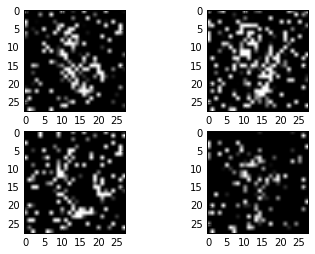

In [72]:
h.plot(new_b.batches[0].next()[0])

In [73]:
old_b = b.Permutation_batches(batch_size, n = 10, n_perm = 768, version = 'old')

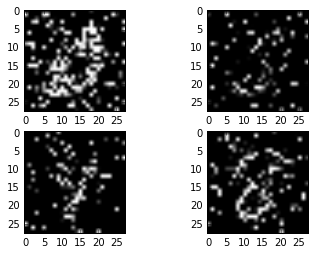

In [74]:
h.plot(old_b.batches[0].next()[0])

# Tensorflow MLP

In [75]:
Model = mlp_tensorlayer.Model

## Training routine

In [76]:
def restore(sess):
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoint_directory/{}'.format(model_name)))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

In [285]:
max_steps = 3001
period_print = 500
period_stat = 100

def train(model, batches_list, data = None, EWC = False, stat = False):
    
    acc_track = [[] for i in range(len(data))]
    
    p = h.Progress(max_steps*len(batches_list))
    pr = 0
    
    for ind, batches in enumerate(batches_list):
        #print("Training on batches{0}\n".format(ind+1))
        try:
            for step in range(max_steps):
                
                pr = pr+1
                p.update(pr)
                
                X, y = batches.next()
                train_d = {model.x : X, model.y_ : y}

                if EWC ==  False:
                    _ = sess.run(model.train_op, feed_dict=train_d)
                if EWC ==  True:
                    _ = sess.run(model.train_op_ewc, feed_dict=train_d)

                if step % period_stat == 0:
                    for i, d in enumerate(data):
                        acc_track[i].append(test_acc(model, d[0], d[1]))


                if (step % period_print == 0) and (stat == True):
                    test_d = {model.tf_x : X, model.tf_y : y}
                    l,ll, train_pred = sess.run([model.cost, model.ewc_cost, model.pred], feed_dict=test_d)
                    print(
                        "Step {0}: \n loss: {1} {2} \n minibatch acc: {3}% \n".format(
                            step,
                            l,
                            ll,
                            accuracy(train_pred, y)
                        )
                    )
            set_constraint(model, X, y)

        except KeyboardInterrupt:
            set_constraint(model, X, y)
            print('training interrupted')

    return acc_track

In [286]:
def test_acc(model, X, y):
    test_d = {model.x : X, model.y_ : y}
    accuracy = sess.run([model.acc], feed_dict=test_d)
    return accuracy            

In [287]:
def get_gradient(model, batches):
    X, y = batches.next()
    test_d = {model.x : X, model.y_ : y}
    gradient = sess.run([model.grads], feed_dict=test_d)
    return gradient

In [288]:
# Привязать к данным
def set_constraint(model, X, y):
    # Вычисляем Градиент по весам
    test_d = {model.x : X, model.y_ : y}
    g = sess.run([model.grads], feed_dict=test_d)

    for i, m in enumerate(model.network.all_params):
        name = m.name.split("/")[0]
        grad, w = g[0][i]
        
        with sess.as_default():
            model.f[name].assign(0.3 * np.square(grad) + 0.7 * model.f[name].eval()).eval()
            model.w[name].assign(w).eval()
   

In [289]:
def plot(acc_track, title):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rc("font", size=10)
    fig = plt.figure()
    fig.suptitle(title, fontsize=14)
    axes = plt.gca()
    axes.set_ylim([0,100])
    l = len(acc_track[0])
    for ind, acc in enumerate(acc_track):
        plt.plot(range(l), np.multiply(acc_track[ind],100.0), label='Batches {0}'.format(ind))

    plt.ylabel('accuracy, %')
    plt.xlabel('number of training batches x100')
    plt.legend(loc=4, borderaxespad=0.)
    plt.show()

## Training

## Part1 ( на изображениях из MNIST с различными шумами)

### Описание:
batches1 - batches5 - изображения из датасета MNIST с различными шумами ( в каждом - некоторый фиксированный случайный набор пар пикселей, в каждой паре пиксели меняются местами ).

Сеть - с двумя скрытыми слоями без байесов, активации - ReLU.

Сеть последовательно обучается на батчах из batches1 - batches5, в поцессе обучения сети измеряется точность классификаци на batches1 - batches5.

В одном случае мы просто обучаем сеть последовательно, без исползования EWC, a во втором случае после окончания тренировке на одной задаче, происходит обновление коэффициетнов матрицы Фишера и равновесных весов по формуле: 

$$
F_{i+1} = 0.3 \cdot F_{new} + 0.7 \cdot F_i
$$

$$
h_{e(i+1)} = h_{i}
$$

Выполним несколько прогонов, последовательно уменьшая колличество нейронов на скрытых слоях в два раза.

(l1, l2) - колличество нейронов на первом и втором скрытом слое.

# 1. Сравним модели со старыми и новыми батчами

### Without EWC

In [102]:
model = Model([784,5,5,10],{'l1':0.0,'l2':0.0,'ewc':0.0})
sess = tf.Session(graph=model.graph)
sess.run(model.init)
data = []

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 5 relu
  [TL] DenseLayer  relu2: 5 relu
  [TL] DenseLayer  output_layer: 10 identity


In [103]:
y_train = old_b.train[1]

In [104]:
data.append(train(model, old_b.batches[0:5], old_b.permutations[:5], EWC=False))

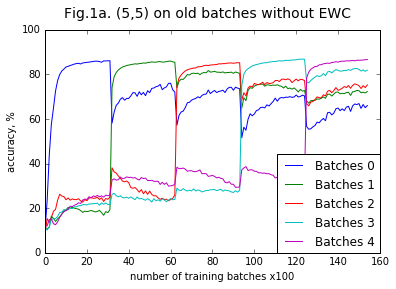

In [108]:
plot(data[0], "Fig.1a. (5,5) on old batches without EWC")

In [106]:
sess.run(model.init)
data.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=False))

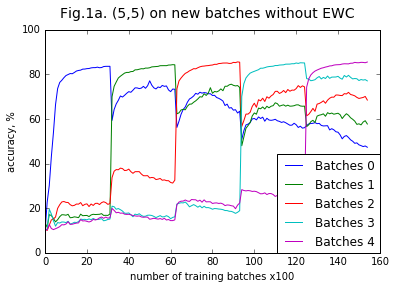

In [107]:
plot(data[1], "Fig.1b. (5,5) on new batches without EWC")

### With EWC

In [109]:
model = Model([784,16,16,10],{'l1':0.0,'l2':0.0,'ewc':1e15})
sess = tf.Session(graph=model.graph)
sess.run(model.init)
data2 = []

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity


In [110]:
data2.append(train(model, old_b.batches[0:5], old_b.permutations[:5], EWC=True))

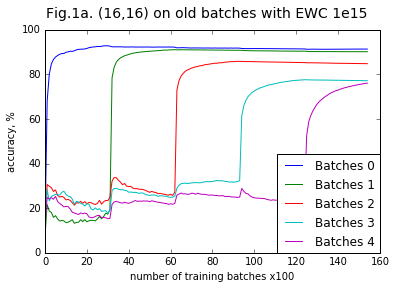

In [112]:
plot(data2[0], "Fig.2a. (16,16) on old batches with EWC 1e15")

In [113]:
sess.run(model.init)
data2.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=True))

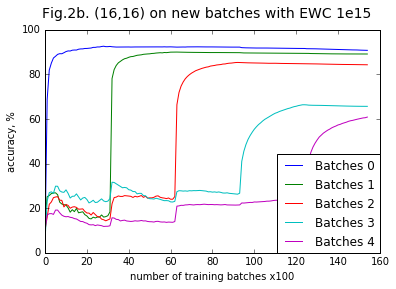

In [114]:
plot(data2[1], "Fig.2b. (16,16) on new batches with EWC 1e15")

### Выводы:

Делйствительно существует эффект, обусловленный присутствием одинаковых перестановок в разных батчах.

В старых батчах за счет некоторого колличества общих перестановок задачи более похожи, их коэффициенты Фишера более похожи, сеть с EWC декрадирует медленнее. **ToDo: показать через Fisher overlap**

В дальнейшем будут использоваться новые батчи.

# 2) Подбор параметра EWС и сравнение SGD и Adam

### Для Adam

In [116]:
ewc_search = [1e3, 1e5, 1e8, 1e10, 1e12, 1e15, 1e18]

In [117]:
data3 = []

for ewc in ewc_search:
    model = Model([784,16,16,10],{'l1':0.0,'l2':0.0,'ewc':ewc})
    sess = tf.Session(graph=model.graph)
    sess.run(model.init)
    
    data3.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=True))

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
 

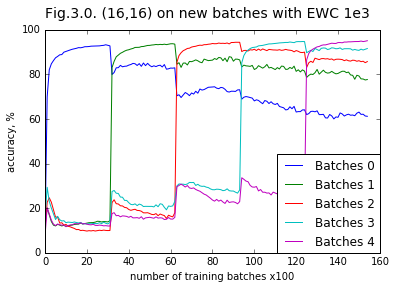

In [121]:
plot(data3[0], "Fig.3.0. (16,16) on new batches with EWC 1e3")

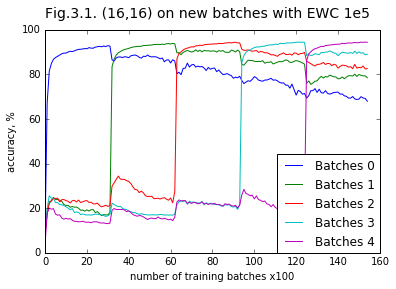

In [122]:
plot(data3[1], "Fig.3.1. (16,16) on new batches with EWC 1e5")

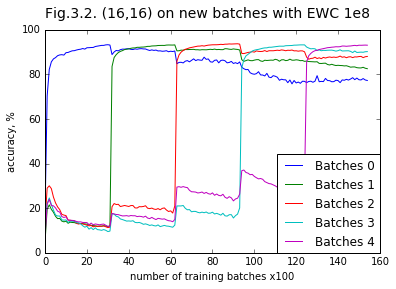

In [129]:
plot(data3[2], "Fig.3.2. (16,16) on new batches with EWC 1e8")

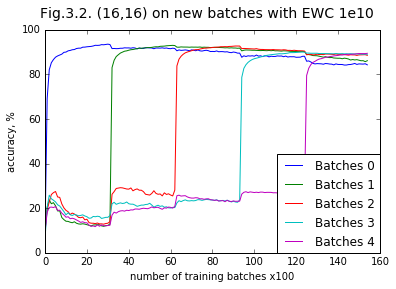

In [124]:
plot(data3[3], "Fig.3.3. (16,16) on new batches with EWC 1e10")

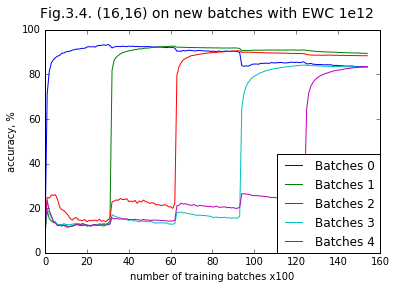

In [126]:
plot(data3[4], "Fig.3.4. (16,16) on new batches with EWC 1e12")

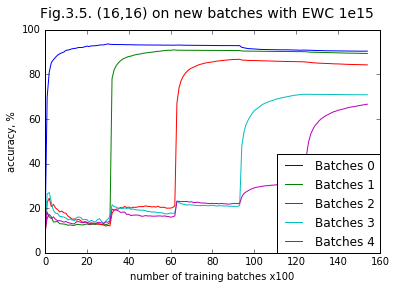

In [127]:
plot(data3[5], "Fig.3.5. (16,16) on new batches with EWC 1e15")

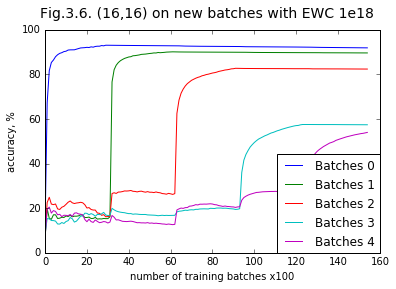

In [128]:
plot(data3[6], "Fig.3.6. (16,16) on new batches with EWC 1e18")

### Выводы:

Более высокие значения EWC константы полностью препятствуют забыванию предыдущих задач, но снижают емкость сети для выучивание новых.

## Для SGD

In [155]:
mlp_tensorlayer = reload(mlp_tensorlayer)
Model = mlp_tensorlayer.Model

In [189]:
model = Model([784,16,16,10],{'l1':0.0,'l2':0.0,'ewc':0.0,'lr':0.1}, optimizer = 'SGD')
sess = tf.Session(graph=model.graph)
sess.run(model.init)
data4 = [] 
model.optimizer

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity


In [190]:
data4.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=False))

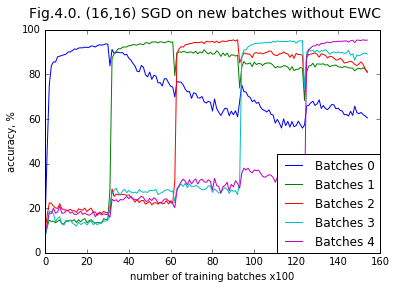

In [191]:
plot(data4[0], "Fig.4.0. (16,16) SGD on new batches without EWC ")

### Будем использовать более простые искажения (400)

In [184]:
mlp_tensorlayer = reload(mlp_tensorlayer)
Model = mlp_tensorlayer.Model

In [185]:
new_b2 = b.Permutation_batches(batch_size, n = 10, n_perm = 400, version = 'new')

In [186]:
model = Model([784,64,64,10],{'l1':0.0,'l2':0.0,'ewc':0.0, 'lr':0.1}, optimizer = 'SGD')
sess = tf.Session(graph=model.graph)
sess.run(model.init)
data5 = [] 
model.optimizer

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity


In [187]:
data5.append(train(model, new_b2.batches[0:5], new_b2.permutations[:5], EWC=False))

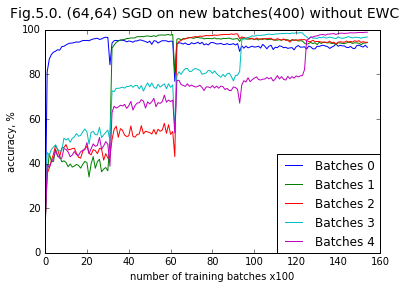

In [188]:
plot(data5[0], "Fig.5.0. (64,64) SGD on new batches(400) without EWC ")

### На стандартных искажениях (768)

In [192]:
data6 = []

for ewc in ewc_search:
    model = Model([784,16,16,10],{'l1':0.0,'l2':0.0,'ewc':ewc, 'lr':0.1}, optimizer = 'SGD')
    sess = tf.Session(graph=model.graph)
    sess.run(model.init)
    
    data6.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=True))

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
  [TL] DenseLayer  relu2: 16 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 16 relu
 

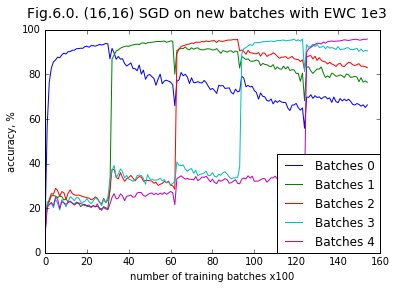

In [195]:
plot(data6[0], "Fig.6.0. (16,16) SGD on new batches with EWC 1e3")

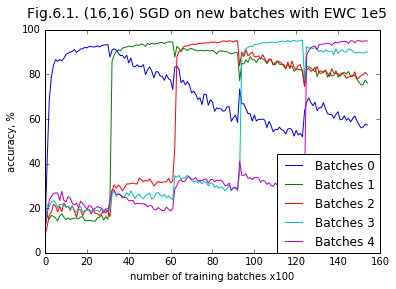

In [197]:
plot(data6[1], "Fig.6.1. (16,16) SGD on new batches with EWC 1e5")

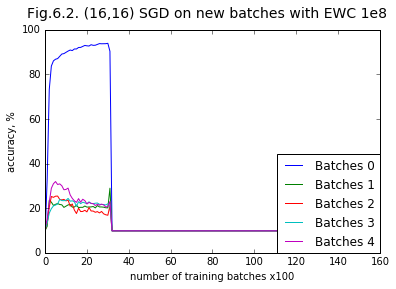

In [198]:
plot(data6[2], "Fig.6.2. (16,16) SGD on new batches with EWC 1e8")

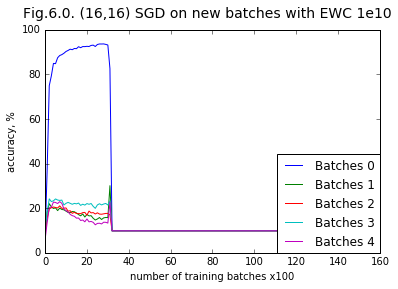

In [199]:
plot(data6[3], "Fig.6.0. (16,16) SGD on new batches with EWC 1e10")

### И дальше фейл

In [200]:
ewc_search2 = [3e5,1e6,3e6,1e7,3e7]
data7 = []

for ewc in ewc_search2:
    model = Model([784,64,64,10],{'l1':0.0,'l2':0.0,'ewc':ewc, 'lr':0.1}, optimizer = 'SGD')
    sess = tf.Session(graph=model.graph)
    sess.run(model.init)
    
    data7.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=True))

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity


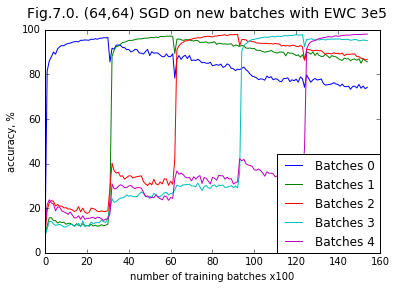

In [275]:
plot(data7[0], "Fig.7.0. (64,64) SGD on new batches with EWC 3e5")

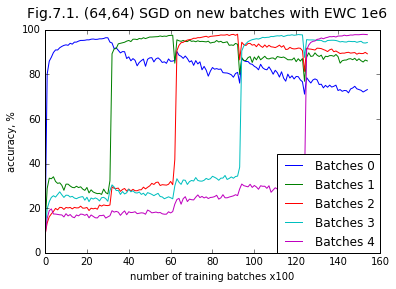

In [276]:
plot(data7[1], "Fig.7.1. (64,64) SGD on new batches with EWC 1e6")

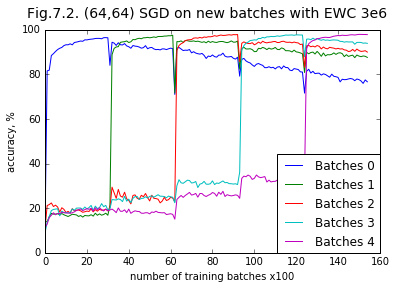

In [277]:
plot(data7[2], "Fig.7.2. (64,64) SGD on new batches with EWC 3e6")

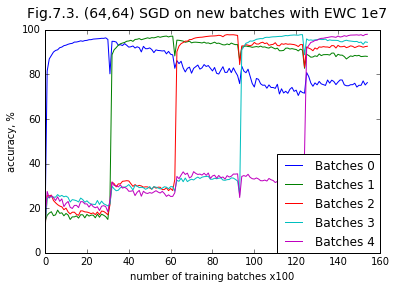

In [278]:
plot(data7[3], "Fig.7.3. (64,64) SGD on new batches with EWC 1e7")

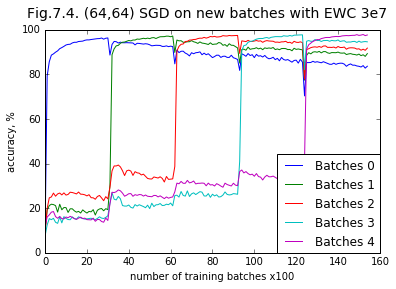

In [279]:
plot(data7[4], "Fig.7.4. (64,64) SGD on new batches with EWC 3e7")

In [211]:
ewc_search3 = [1e8,1e9,1e10,1e11,1e12,1e15]
data8 = []

for ewc in ewc_search3:
    model = Model([784,64,64,10],{'l1':0.0,'l2':0.0,'ewc':ewc, 'lr':0.1}, optimizer = 'SGD')
    sess = tf.Session(graph=model.graph)
    sess.run(model.init)
    
    data8.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=True))

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity
  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 64 relu
  [TL] DenseLayer  relu2: 64 relu
  [TL] DenseLayer  output_layer: 10 identity


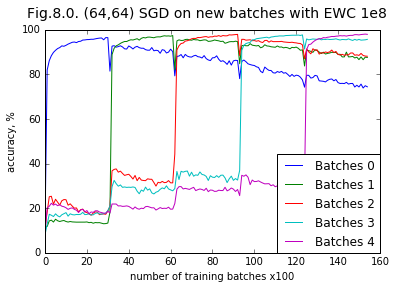

In [280]:
plot(data8[0], "Fig.8.0. (64,64) SGD on new batches with EWC 1e8")

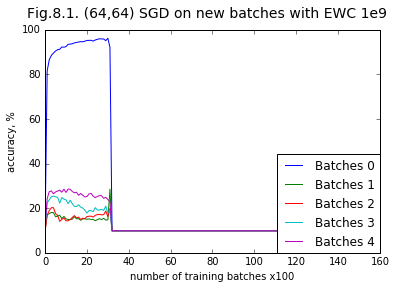

In [281]:
plot(data8[1], "Fig.8.1. (64,64) SGD on new batches with EWC 1e9")

In [216]:
model = Model([784,128,128,10],{'l1':0.0,'l2':0.0,'ewc':1e10, 'lr':0.1}, optimizer = 'SGD')
sess = tf.Session(graph=model.graph)
sess.run(model.init)
    
data8.append(train(model, new_b.batches[0:5], new_b.permutations[:5], EWC=True))

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 128 relu
  [TL] DenseLayer  relu2: 128 relu
  [TL] DenseLayer  output_layer: 10 identity


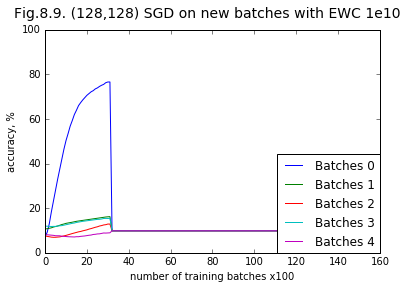

In [283]:
plot(data8[8], "Fig.8.9. (128,128) SGD on new batches with EWC 1e10")

### На батчах (400)

In [268]:
model = Model([784,128,128,10],{'l1':0.0,'l2':0.0,'ewc':1e10, 'lr':0.001}, optimizer = 'SGD')
sess = tf.Session(graph=model.graph)
sess.run(model.init)
    
data8.append(train(model, new_b2.batches[0:5], new_b2.permutations[:5], EWC=True))

  [TL] InputLayer  input_layer: (?, 784)
  [TL] DenseLayer  relu1: 128 relu
  [TL] DenseLayer  relu2: 128 relu
  [TL] DenseLayer  output_layer: 10 identity


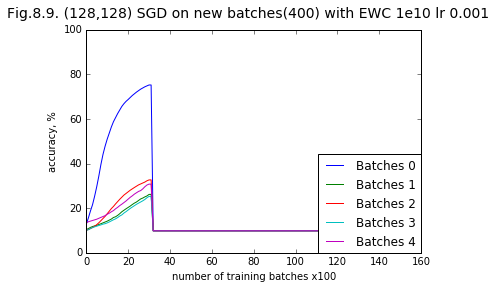

In [284]:
plot(data8[9], "Fig.8.9. (128,128) SGD on new batches(400) with EWC 1e10 lr 0.001")

## Note: Авторы оригинальной статьи использовали 400 нейронов и два скрытых слоя.

Ну, в общем SGD расходится :(

У SGD проблемы с learning rate( 

# Выводы

Техника EWC, предложенная DeepMind, позволяет эффективно бороться с забыванием нейросетями старых задач в процессе обучения новым. Это достигается путем избирательного ограничение learning rate на весах, играющих важную роль в решении предыдущих задач.


С уменьшением колличества нейронов на скрытых слоях уменьшается способность модели с EWC эффективно выучивать большое колличество задач.